In [1]:
import os,sys
sys.path.append(os.path.realpath(os.path.join(os.getcwd(), '..')))
import warnings
warnings.filterwarnings("ignore")

In [2]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import CPS

In [3]:
opt = CPS.config()
args = opt.parse_args(['--seed', '2025'])
args.prep_scale = False
args.dataset_path = '/mnt/d/Dataset/SRT_Dataset/MBSS_Sagittal_Posterior'
args.radius=150
args.clusters=6
args.hvgs=2000
args.er_w=0.05
args.sigma=1
args.freq=32
CPS.set_random_seed(args.seed)
args.k_list = [0,1,2,3,4,5,6,7]
# [0,1,2,3,4,5,6,7][0,1,2,3,5,8,13,21][0,1,2,4,6,8,10,12][0,1,2,4,8,16,32,64]
args

Namespace(batch_size=1024, clusters=6, coord_dim=2, dataset_path='/mnt/d/Dataset/SRT_Dataset/MBSS_Sagittal_Posterior', decoder_latent=[256, 512, 1024], distill=1.0, dropout=0.2, embedd_dim=512, er_w=0.05, flow='source_to_target', freq=32, gpu=0, hvgs=2000, inr_latent=[256, 256, 256], k_list=[0, 1, 2, 3, 4, 5, 6, 7], latent_dim=64, lr=0.001, max_epoch=1000, max_neighbors=6, n_spot=0, num_heads=4, prep_scale=False, radius=150, seed=2025, self_loops=True, sigma=1, weight_decay=0.0001)

In [4]:
adata = sc.read_visium(path=args.dataset_path, count_file='filtered_feature_bc_matrix.h5')
adata

AnnData object with n_obs × n_vars = 3355 × 32285
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [5]:
adata.var_names_make_unique()
adata.layers["counts"] = adata.X.copy()
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=args.hvgs)
adata_hvg = adata[:, adata.var['highly_variable']].copy()
sc.pp.normalize_total(adata_hvg, target_sum=1e4)
sc.pp.log1p(adata_hvg)
sc.pp.scale(adata_hvg, zero_center=True, max_value=10)

counts_layer = adata_hvg.layers['counts']
adata_hvg.obsm['hvg_features'] = adata_hvg.X
adata_hvg.obsm['hvg_counts'] = counts_layer.toarray()

In [6]:
spatial_edge = CPS.SpatialGraphBuilder(args)
pyg_data = spatial_edge.build_single_graph(adata_hvg, method='rknn')
print(pyg_data.num_nodes, pyg_data.num_genes, pyg_data.edge_index.shape)

3355 2000 torch.Size([2, 22953])


In [7]:
cps_model = CPS.CPSTrainer(args)
cps_model.fit(pyg_data)

  0%|          | 0/1000 [00:00<?, ?it/s]

0.05197858810424805 2.0792925357818604

Epoch   0: Train[Total:5.6710, T:2.5677, S:2.3270, D:0.7764]
0.05197690799832344 2.079258918762207
0.051974356174468994 2.0792078971862793
0.0519719123840332 2.0791590213775635
0.05196702480316162 2.079061269760132
0.05196361616253853 2.078993082046509
0.0519588366150856 2.078897476196289
0.05195312574505806 2.0787832736968994
0.051948774605989456 2.0786962509155273
0.05194643884897232 2.0786495208740234
0.051942646503448486 2.078573703765869

Epoch  10: Train[Total:2.7762, T:1.2168, S:1.1727, D:0.3868]
0.051941074430942535 2.0785422325134277
0.05193563923239708 2.0784335136413574
0.05193140730261803 2.0783488750457764
0.05192803218960762 2.0782814025878906
0.05192545801401138 2.0782299041748047
0.05192084237933159 2.0781376361846924
0.05191535875201225 2.0780279636383057
0.0519084595143795 2.077889919281006
0.05189716815948486 2.0776641368865967
0.051884688436985016 2.0774145126342773

Epoch  20: Train[Total:2.6031, T:1.1576, S:1.1244, D:0.3211]

0.0 0.8450829982757568


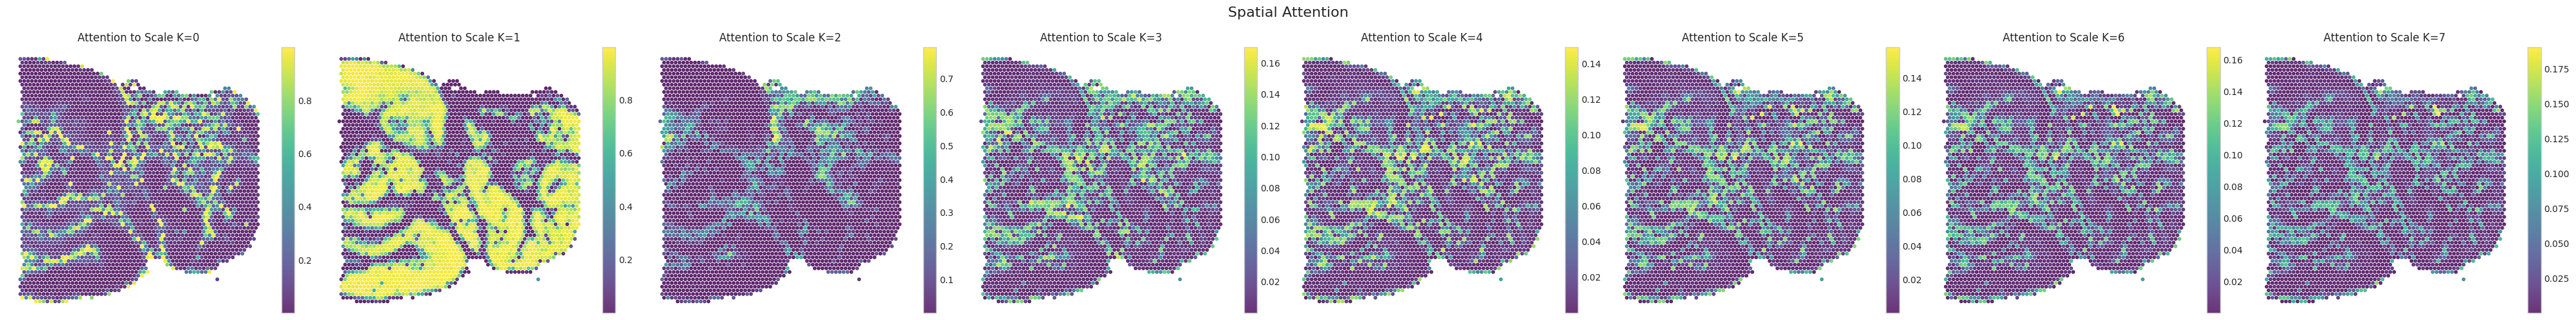

In [8]:
z_s, latent, attn = cps_model.interpret_attn_scores(pyg_data, verbose=True)
adata_hvg.obsm['z_s'] = z_s
adata_hvg.obsm['z_t'] = latent
adata_hvg.obsm['attns'] = attn
adata_hvg.obsm['attn'] = attn.reshape(adata_hvg.n_obs, 32)

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


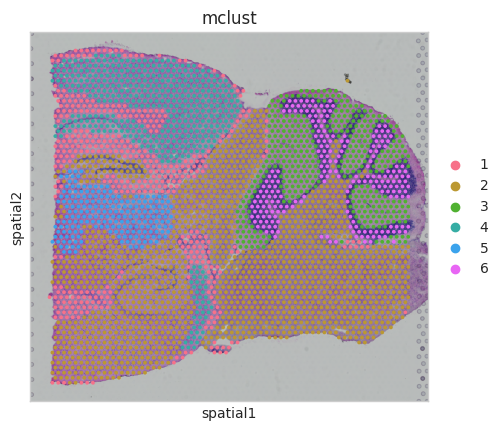

In [11]:
adata_hvg = CPS.mclust(adata_hvg, args, key='z_s', pca_dim=32)
sc.pl.spatial(adata_hvg, img_key="hires", color=["mclust"])

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 8 is different from 4)